# In-Depth: Manifold Learning
We have seen how principal component analysis can be used in the dimensionality
reduction task—reducing the number of features of a dataset while maintaining the
essential relationships between the points. While PCA is flexible, fast, and easily
interpretable, it does not perform so well when there are nonlinear relationships
within the data; we will see some examples of these below.
  To address this deficiency, we can turn to a class of methods known as manifold learn‐
ing—a class of unsupervised estimators that seeks to describe datasets as low-
dimensional manifolds embedded in high-dimensional spaces. When you think of a
manifold, I’d suggest imagining a sheet of paper: this is a two-dimensional object that
lives in our familiar three-dimensional world, and can be bent or rolled in two
dimensions. In the parlance of manifold learning, we can think of this sheet as a two-
dimensional manifold embedded in three-dimensional space.

Rotating, reorienting, or stretching the piece of paper in three-dimensional space
doesn’t change the flat geometry of the paper: such operations are akin to linear
embeddings. If you bend, curl, or crumple the paper, it is still a two-dimensional
manifold, but the embedding into the three-dimensional space is no longer linear.
Manifold learning algorithms would seek to learn about the fundamental two-
dimensional nature of the paper, even as it is contorted to fill the three-dimensional
space.

**Here we will demonstrate a number of manifold methods, going most deeply into a
couple techniques: multidimensional scaling (MDS), locally linear embedding (LLE),
and isometric mapping (Isomap). We begin with the standard imports:**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

/home/qalmaqihir/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Manifold Learning: “HELLO”
To make these concepts more clear, let’s start by generating some two-dimensional
data that we can use to define a manifold. Here is a function that will create data in
the shape of the word “HELLO”:

In [9]:
def make_hello(N=1000, rseed=42):
    # make a plot with 'HELLO' text; save as PNG
    fig, ax = plt.subplots(figsize=(4,1))
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax.axis('off')
    ax.text(0.5,0.4,"HELLO",va='center',ha='center',weight='bold',size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw a random points from it
    from matplotlib.image import imread
    data=imread('hello.png')[::-1,:,0].T
    rng=np.random.RandomState(rseed)
    X=rng.rand(4*N,2)
    i,j = (X * data.shape).astype(int).T
    mask = (data[i,j]<1)
    X=X[mask]
    
    X[:,0]*=(data.shape[0]/data.shape[1])
    X=X[:N]
    return X[np.argsort(X[:,0])]


In [10]:
# lets call the function and visualize the resulting data
X=make_hello(1000)

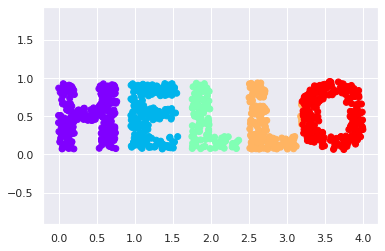

In [11]:
colorize=dict(c=X[:,0],cmap=plt.cm.get_cmap('rainbow',5))
plt.scatter(X[:,0],X[:,1],**colorize)
plt.axis('equal');

___The output is two dimensional, and consists of points drawn in the shape of the word
“HELLO”. This data form will help us to see visually what these algorithms are doing.___

## Multidimensional Scaling (MDS)
Looking at data like this, we can see that the particular choice of x and y values of the
dataset are not the most fundamental description of the data: we can scale, shrink, or
rotate the data, and the “HELLO” will still be apparent. For example, if we use a rota‐
tion matrix to rotate the data, the x and y values change, but the data is still funda‐
mentally the same

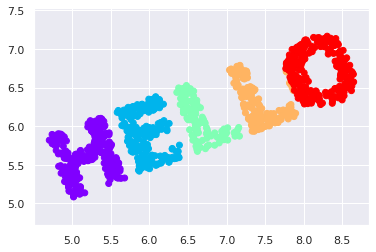

In [14]:
def rotate(X,angle):
    theta=np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
        [-np.sin(theta),np.cos(theta)]]
    return np.dot(X,R)

X2=rotate(X,20)+5
plt.scatter(X2[:,0],X2[:,1],**colorize)
plt.axis('equal');

This tells us that the x and y values are not necessarily fundamental to the relation‐
ships in the data. What is fundamental, in this case, is the distance between each point
and the other points in the dataset. A common way to represent this is to use a dis‐
tance matrix: for N points, we construct an N × N array such that entry i, j contains
the distance between point i and point j. Let’s use Scikit-Learn’s efficient pair
wise_distances function to do this for our original data:

In [15]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

/tmp/ipykernel_87535/2229922192.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar();


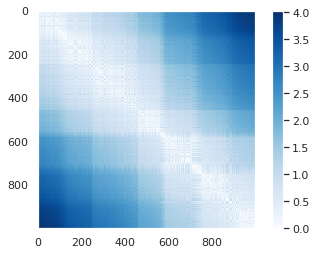

In [16]:
# for our = 1000 points we obtained a 1000x1000 matrix, which can be visulize
plt.imshow(D,zorder=2,cmap='Blues', interpolation='nearest')
plt.colorbar();

In [17]:
# if we similarly construct a distance matrix for our rotation and translated data
D2 = pairwise_distances(X2)
np.allclose(D,D2)

True

This distance matrix gives us a representation of our data that is invariant to rotations
and translations, but the visualization of the matrix is not entirely intuitive. In the
representation presented in Figure 5-96, we have lost any visible sign of the interest‐
ing structure in the data: the “HELLO” that we saw before.

Further, while computing this distance matrix from the (x, y) coordinates is straight‐
forward, transforming the distances back into x and y coordinates is rather difficult.
This is exactly what the multidimensional scaling algorithm aims to do: given a dis‐
tance matrix between points, it recovers a D-dimensional coordinate representation
of the data. Let’s see how it works for our distance matrix, using the precomputed
dissimilarity to specify that we are passing a distance matrix

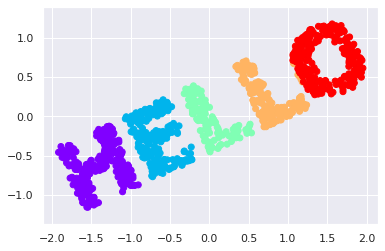

In [18]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:,0],out[:,1],**colorize)
plt.axis('equal');

The MDS algorithm recovers one of the possible two-dimensional coordinate repre‐
sentations of our data, using only the N × N distance matrix describing the relation‐
ship between the data points.

## MDS as Manifold Learning
The usefulness of this becomes more apparent when we consider the fact that dis‐
tance matrices can be computed from data in any dimension. So, for example, instead
of simply rotating the data in the two-dimensional plane, we can project it into three
dimensions using the following function (essentially a three-dimensional generaliza‐
tion of the rotation matrix used earlier)

In [20]:
def random_projection(X,dimension=3, rseed=42):
    assert dimension >=X.shape[1]
    rng=np.random.RandomState(rseed)
    C = rng.randn(dimension,dimension)
    e,V = np.linalg.eigh(np.dot(C,C.T))
    return np.dot(X, V[:X.shape[1]])

X3 = random_projection(X,3)
X3.shape

(1000, 3)

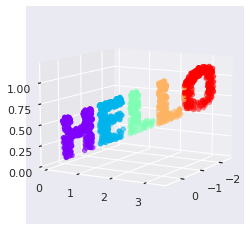

In [28]:
# let's visualize these points to see what we're working with
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:,0],X3[:,1],X3[:,2], **colorize)
ax.view_init(azim=30,elev=10)

We can now ask the MDS estimator to input this three-dimensional data, compute the
distance matrix, and then determine the optimal two-dimensional embedding for this
distance matrix. The result recovers a representation of the original data

(-2.1078941190806093,
 2.146329577637039,
 -1.2702963324586083,
 1.2918301788213242)

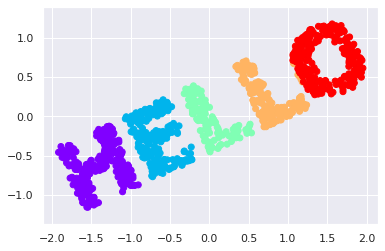

In [30]:
model = MDS(n_components=2, random_state=1)
out3=model.fit_transform(X3)
plt.scatter(out3[:,0],out3[:,1], **colorize)
plt.axis('equal')

This is essentially the goal of a manifold learning estimator: given high-dimensional
embedded data, it seeks a low-dimensional representation of the data that preservescertain relationships within the data. In the case of MDS, the quantity preserved is the
distance between every pair of points.


## Nonlinear Embeddings: Where MDS Fails
Our discussion so far has considered linear embeddings, which essentially consist of
rotations, translations, and scalings of data into higher-dimensional spaces. Where
MDS breaks down is when the embedding is nonlinear—that is, when it goes beyond
this simple set of operations. Consider the following embedding, which takes the
input and contorts it into an “S” shape in three dimensions:

In [32]:
def make_hello_s_curve(X):
    t=(X[:,0]-2)*0.75*np.pi
    x=np.sin(t)
    y=X[:,1]
    z=np.sign(t)*(np.cos(t)-1)
    return np.vstack((x,y,z)).T

Xs=make_hello_s_curve(X)

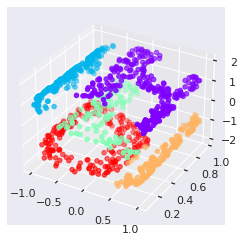

In [33]:
#this is again 3-d data, but we can see tht the embedding is much more complicated
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(Xs[:,0],Xs[:,1],Xs[:,2],**colorize);

The fundamental relationships between the data points are still there, but this time
the data has been transformed in a nonlinear way: it has been wrapped up into the
shape of an “S.”  If we try a simple MDS algorithm on this data, it is not able to “unwrap” this nonlin‐
ear embedding, and we lose track of the fundamental relationships in the embedded
manifold

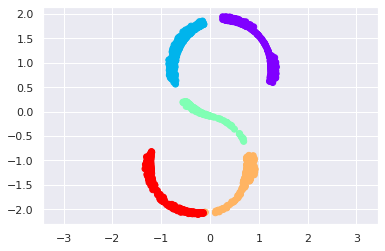

In [34]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outs=model.fit_transform(Xs)
plt.scatter(outs[:,0],outs[:,1],**colorize)
plt.axis('equal');

The best two-dimensional linear embedding does not unwrap the S-curve, but
instead throws out the original y-axis

## Nonlinear Manifolds: Locally Linear Embedding
How can we move forward here? Stepping back, we can see that the source of the
problem is that MDS tries to preserve distances between faraway points when con‐
structing the embedding. But what if we instead modified the algorithm such that it
only preserves distances between nearby points? The resulting embedding would be
closer to what we want.  

LLE comes in a number of flavors; here we will use the modified LLE algorithm to
recover the embedded two-dimensional manifold. In general, modified LLE does bet‐
ter than other flavors of the algorithm at recovering well-defined manifolds with very
little distortion

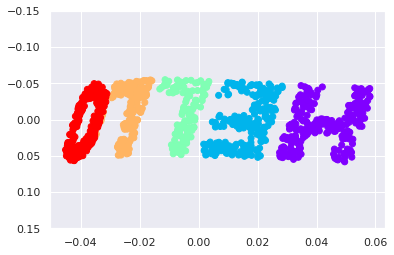

In [37]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')

out = model.fit_transform(Xs)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

The result remains somewhat distorted compared to our original manifold, but captures the essential relationships in the data!

## Some Thoughts on Manifold Methods
Though this story and motivation is compelling, in practice manifold learning tech‐
niques tend to be finicky enough that they are rarely used for anything more than
simple qualitative visualization of high-dimensional data.
The following are some of the particular challenges of manifold learning, which all
contrast poorly with PCA:  
• In manifold learning, there is no good framework for handling missing data. In
contrast, there are straightforward iterative approaches for missing data in PCA.  
• In manifold learning, the presence of noise in the data can “short-circuit” the
manifold and drastically change the embedding. In contrast, PCA naturally filters
noise from the most important components.  
• The manifold embedding result is generally highly dependent on the number of
neighbors chosen, and there is generally no solid quantitative way to choose an
optimal number of neighbors. In contrast, PCA does not involve such a choice.  
• In manifold learning, the globally optimal number of output dimensions is diffi‐
cult to determine. In contrast, PCA lets you find the output dimension based on
the explained variance.  
• In manifold learning, the meaning of the embedded dimensions is not always
clear. In PCA, the principal components have a very clear meaning.  
• In manifold learning the computational expense of manifold methods scales as
O[N2] or O[N3]. For PCA, there exist randomized approaches that are generally
much faster (though see the megaman package for some more scalable imple‐
mentations of manifold learning).